In [7]:
import glob
import sys
import numpy as np
import os

import pandas as pd
import scipy.io as sio
# import tensorflow as tf
import shutil
from tqdm.auto import tqdm

import cv2
from PIL import Image
import io
from easydict import EasyDict
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH =  r'C:\Users\khanz\PycharmProjects\inno_ds\final_project\data\merged_data'

In [3]:
# https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
ROOT_DIR = 'C:/Users/khanz/PycharmProjects/inno_ds/final_project/data/102flowers'
flowers102_cfg = EasyDict()
flowers102_cfg.labels_file = os.path.join(ROOT_DIR, 'imagelabels.mat')
flowers102_cfg.images_path = os.path.join(ROOT_DIR, 'jpg')

In [4]:
# https://medium.com/analytics-vidhya/how-to-read-tfrecords-files-in-pytorch-72763786743f
ROOT_DIR = 'C:/Users/khanz/PycharmProjects/inno_ds/final_project/data/tpu-getting-started'
flowers_tpu_cfg = EasyDict()
flowers_tpu_cfg.images_path = os.path.join(ROOT_DIR, 'tfrecords-jpeg-331x331')

In [5]:
# https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
ROOT_DIR = 'C:/Users/khanz/PycharmProjects/inno_ds/final_project/data/Flowers Recognition'
flowers_rec_cfg = EasyDict()
flowers_rec_cfg.images_path = os.path.join(ROOT_DIR, 'flowers')
flowers_rec_cfg.categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Подготовка датасетов

In [ ]:
def merge_data(dataset_cfgs, path_to_save):
    # сливание трех датасетов в один, формирование новой нумерации классов
    merged_df = pd.DataFrame()
    start_class_num = 0
    for dataset_name, cfg in dataset_cfgs.items():
        merged_data_path = os.path.join(path_to_save, dataset_name)
        if not os.path.exists(merged_data_path):
            os.mkdir(merged_data_path)
        df = getattr(sys.modules[__name__], f'{dataset_name}_preprocess')(cfg, merged_data_path)
        labels = np.unique(df['label'])
        label2global = {l: i + start_class_num for i, l in enumerate(labels)}
        df['label'] = df['label'].map(label2global)
        start_class_num = start_class_num + len(labels)

        merged_df = pd.concat([merged_df, df], ignore_index=True)
    merged_df.to_csv(os.path.join(path_to_save, 'annotation.csv'), index=False)


def flowers102_preprocess(cfg, path_to_save):
    labels = sio.loadmat(cfg.labels_file)['labels'].flatten()
    image_paths = []
    for path in tqdm(os.listdir(cfg.images_path), 'Copy files'):
        src = os.path.join(cfg.images_path, path)
        dst = os.path.join(path_to_save, path)

        if os.path.exists(dst):
            print(path)
        shutil.copyfile(src, dst)

        image_paths.append('/'.join(dst.split('\\')[-2:]))

    return pd.DataFrame(data={'path': image_paths, 'label': labels})


def flowers_rec_preprocess(cfg, path_to_save):
    image_paths, labels = [], []
    for i, cat in enumerate(cfg.categories):
        for path in tqdm(os.listdir(os.path.join(cfg.images_path, cat)), f'category - {cat}'):
            src = os.path.join(cfg.images_path, cat, path)
            dst = os.path.join(path_to_save, path)

            if os.path.exists(dst):
                print(path)
            shutil.copyfile(src, dst)

            image_paths.append('/'.join(dst.split('\\')[-2:]))
            labels.append(i)

    return pd.DataFrame(data={'path': image_paths, 'label': labels})


def flowers_tpu_preprocess(cfg, path_to_save):
    train_feature_description = {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, train_feature_description)

    image_paths, labels = [], []
    for data_type in ['train', 'val']:
        files = glob.glob(cfg.images_path + f'/{data_type}/*.tfrec')
        for i in tqdm(files, desc=f'{data_type}'):
            train_image_dataset = tf.data.TFRecordDataset(i)
            train_image_dataset = train_image_dataset.map(_parse_image_function)
            ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset]
            labels.extend([int(class_features['class'].numpy()) for class_features in train_image_dataset])
            images = [image_features['image'].numpy() for image_features in train_image_dataset]
            for _id, img in zip(ids, images):
                dst = os.path.join(path_to_save, f"{_id}.jpeg")
                img = cv2.cvtColor(np.asarray(Image.open(io.BytesIO(img))), cv2.COLOR_RGB2BGR)
                cv2.imwrite(dst, img)
                image_paths.append('/'.join(dst.split('\\')[-2:]))

    return pd.DataFrame(data={'path': image_paths, 'label': labels})

In [ ]:
dataset_configs = {
    'flowers_tpu': flowers_tpu_cfg,
    'flowers_rec': flowers_rec_cfg,
    'flowers102': flowers102_cfg
}
merge_data(dataset_configs, DATASET_PATH)

## Объединение дубликатов по классам

In [ ]:
annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation.csv'))
ignore_classes = [4, 113]

# map для 102flowers и flowers_rec
map_dict = {i: i for i in np.unique(annot['label'])}
map_dict.update({107: 162, 105: 158, 104: 157, 106: 182})

new_annot = annot.copy()
new_annot['label'] = annot['label'].map(map_dict)

map_dict = {i: i for i in np.unique(new_annot['label'])}

classes_counts = new_annot['label'].value_counts()

# объединение 102flowers и flowers_tpu
combine_classes = [(i, i + 109) for i in np.arange(0, 102) if i not in ignore_classes]
combine_classes += [(102, 108)]
dropped_classes = []
for current_class, another_class in combine_classes:
    current_class_len = classes_counts[current_class]
    another_class_len = classes_counts[another_class]

    if current_class_len > another_class_len:
        dropped_classes.append(another_class)
    else:
        dropped_classes.append(current_class)
new_annot = new_annot[~new_annot['label'].isin(dropped_classes)]
map_dict = {cl: i for i, cl in enumerate(np.unique(new_annot['label']))}
new_annot['label'] = new_annot['label'].map(map_dict)
new_annot.to_csv(os.path.join(DATASET_PATH, 'annotation_updated.csv'), index=False)

## Разбиение данных на тестовую и обучающую выборки

In [11]:
def split_data(annot_df, part=0.40):
    classes, counts = np.unique(annot_df['label'], return_counts=True)
    test_len = int(len(classes) * part)
    test_classes = np.random.choice(classes, test_len, replace=False)
    train_classes = np.setdiff1d(classes, test_classes)

    test_classes, counts = np.unique(annot_df[annot_df['label'].isin(test_classes)]['label'], return_counts=True)
    print(len(test_classes), np.sum(counts))
    print(test_classes)
    print(counts)

    train_classes, counts = np.unique(annot_df[annot_df['label'].isin(train_classes)]['label'], return_counts=True)
    print(len(train_classes), np.sum(counts))

    return train_classes, test_classes

In [33]:
annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation_updated.csv'))
train_classes, test_classes = split_data(annot)
annot_train = annot[annot['label'].isin(train_classes)].reset_index()[['path', 'label']]
annot_test = annot[annot['label'].isin(test_classes)].reset_index()[['path', 'label']]

42 8687
[  0   3   4   6   8  10  17  18  22  23  24  25  29  30  32  33  41  43
  48  49  51  64  66  68  69  73  75  78  79  80  81  82  84  85  87  89
  95  96  98 101 102 103]
[ 351  136  112  176  340  116   94  124  337  259  135  148  336  121
  177  216  173  155  169  164  959   91   40   45   46  108   41   40
  813 1144  794   71  114   67   50   52   63   58   82   63   49   58]
63 10724


In [ ]:
annot_train.to_csv(os.path.join(DATASET_PATH, 'annotation_train.csv'), index=False)
annot_test.to_csv(os.path.join(DATASET_PATH, 'annotation_test_all.csv'), index=False)

## Подготовка query и retrieval set для тестовой выборки

In [16]:
annot_test = pd.read_csv(os.path.join(DATASET_PATH, 'annotation_test_all.csv'))

classes, counts = np.unique(annot_test['label'], return_counts=True)

img_paths, labels = [], []
new_annot = pd.DataFrame()
for cl, c in zip(classes, counts):
    s = min(c, 8)
    indices = np.random.choice(annot_test[annot_test['label'] == cl].index.tolist(), size=s)
    new_annot = new_annot.append(annot_test.loc[indices], ignore_index=True)

In [ ]:
new_annot.to_csv(os.path.join(DATASET_PATH, 'annotation_test.csv'), index=False)

In [20]:
# сохранение в одну папку
annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation_test.csv'))
for i, row in annot.iterrows():
    src = os.path.join(DATASET_PATH, row['path'])
    dst = os.path.join(DATASET_PATH, 'test_set', f"{row['label']}_{i}.jpeg")
    shutil.copyfile(src, dst)

In [21]:
old_annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation.csv'))
new_annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation_updated.csv'))
old_annot.shape, new_annot.shape

## Распределение классов в выборках

In [8]:
train_annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation_train.csv'))
test_annot = pd.read_csv(os.path.join(DATASET_PATH, 'annotation_test.csv'))

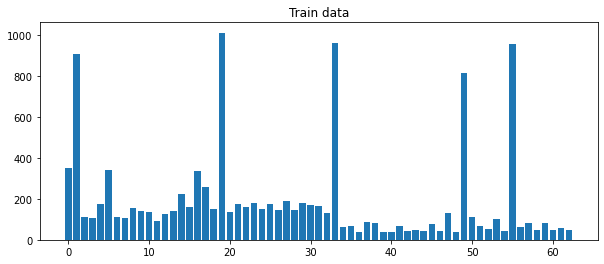

In [20]:
classes, counts = np.unique(train_annot['label'].values, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(classes)), counts)
plt.title(f"Train data")
plt.show()

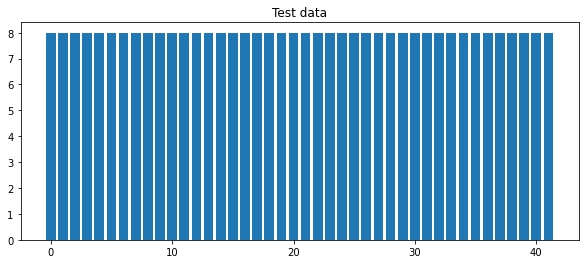

In [21]:
classes, counts = np.unique(test_annot['label'].values, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(classes)), counts)
plt.title(f"Test data")
plt.show()

## Подготовка данных для демонстрации

In [ ]:
path_to_save = r'C:\Users\khanz\PycharmProjects\inno_ds\final_project\data\demo'

train_feature_description = {
    # 'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}


def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, train_feature_description)


image_paths, labels = [], []
for data_type in ['test']:
    files = glob.glob(flowers_tpu_cfg.images_path + f'/{data_type}/*.tfrec')
    for i in tqdm(files, desc=f'{data_type}'):
        train_image_dataset = tf.data.TFRecordDataset(i)
        train_image_dataset = train_image_dataset.map(_parse_image_function)
        ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset]
        # labels.extend([int(class_features['class'].numpy()) for class_features in train_image_dataset])
        images = [image_features['image'].numpy() for image_features in train_image_dataset]
        for _id, img in zip(ids, images):
            dst = os.path.join(path_to_save, f"{_id}.jpeg")
            img = cv2.cvtColor(np.asarray(Image.open(io.BytesIO(img))), cv2.COLOR_RGB2BGR)
            cv2.imwrite(dst, img)
            image_paths.append('/'.join(dst.split('\\')[-2:]))

df = pd.DataFrame(data={'path': image_paths})
df.to_csv(os.path.join(path_to_save, 'annotation_demo.csv'), index=False)